In [39]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


SIZE_X = 256
SIZE_Y = 256
n_classes=3


train_images = []
folder_path = r'E:\DEEP LEARNING SEGMENTATION\Drishti-GS1_files\Drishti-GS1_files\Drishti-GS1_files\Test\Images'
for path in glob.glob(folder_path + '/*.png'):
    img = cv2.imread(path)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(img)

folder_path = r'E:\DEEP LEARNING SEGMENTATION\Drishti-GS1_files\Drishti-GS1_files\Drishti-GS1_files\Training\Images'
for path in glob.glob(folder_path + '/*.png'):
    img = cv2.imread(path)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(img)

train_images = np.array(train_images) 

train_masks = []


base_dir = r"E:\DEEP LEARNING SEGMENTATION\Drishti-GS1_files\Drishti-GS1_files\Drishti-GS1_files\Test\Test_GT"

for i in range(1, 102):  
    str_number = str(i).zfill(3)
    dir_name = "drishtiGS_" + str_number

    full_dir_path = os.path.join(base_dir, dir_name, "SoftMap")
    if os.path.exists(full_dir_path):  # Check if the directory exists
        img_paths = glob.glob(os.path.join(full_dir_path, "*.png"))
        accumulated_img = None
        for img_path in img_paths:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:  
                img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
            if accumulated_img is None:
                accumulated_img = img
            else:
                accumulated_img += img

        if accumulated_img is not None:
            train_masks.append(accumulated_img)

base_dir = r"E:\DEEP LEARNING SEGMENTATION\Drishti-GS1_files\Drishti-GS1_files\Drishti-GS1_files\Training\GT"

for i in range(1, 102):  
    str_number = str(i).zfill(3)
    dir_name = "drishtiGS_" + str_number
    full_dir_path = os.path.join(base_dir, dir_name, "SoftMap")
    if os.path.exists(full_dir_path):  # Check if the directory exists
        img_paths = glob.glob(os.path.join(full_dir_path, "*.png"))
        accumulated_img = None
        for img_path in img_paths:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:  
                img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
            if accumulated_img is None:
                accumulated_img = img
            else:
                accumulated_img += img

        if accumulated_img is not None:
            train_masks.append(accumulated_img)

train_masks = np.array(train_masks)
train_masks= np.where(train_masks <= 127, 0, np.where(train_masks == 128, 1, 2))

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

train_images.shape

c:\users\vvaib\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(101, 256, 256, 3)

In [40]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    return model
 


In [41]:


train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_images.shape)

from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)


from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


def get_model():
    return multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    



_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


(101, 256, 256, 3)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.5263 - loss: 79.4341 - val_accuracy: 0.9737 - val_loss: 6.9268
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.9646 - loss: 8.7037 - val_accuracy: 0.9741 - val_loss: 7.9910
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9692 - loss: 8.0209 - val_accuracy: 0.9740 - val_loss: 6.3591
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9612 - loss: 5.9564 - val_accuracy: 0.9719 - val_loss: 3.8918
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9215 - loss: 3.9556 - val_accuracy: 0.9630 - val_loss: 1.3784
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8709 - loss: 2.8276 - val_accuracy: 0.9579 - val_loss: 1.2621
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8585 - loss: 2.4033 - val_accuracy: 0.9614 - val_loss: 0.9773
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8670 - loss: 1.9076 - val_accuracy: 0.9644 - val_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


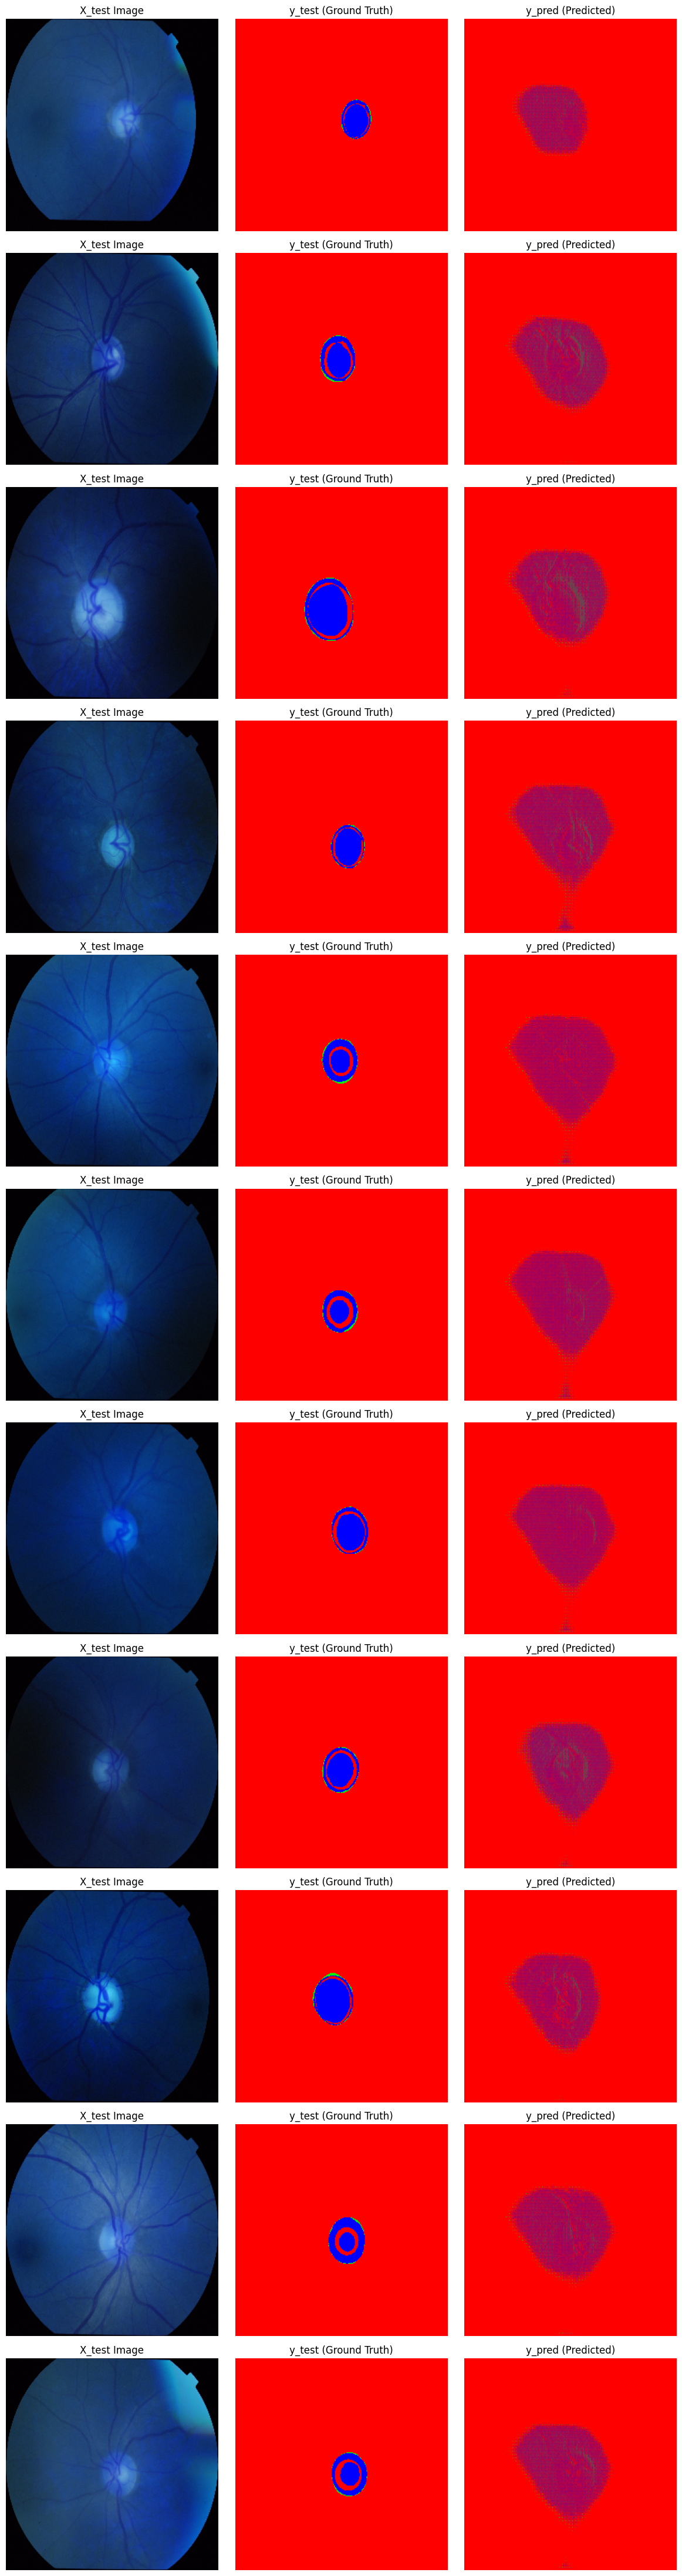

In [43]:
import matplotlib.pyplot as plt

# Assuming X_test contains the test images, y_test contains the ground truth masks,
# and y_pred contains the predicted masks
num_images = len(X_test)

# Set the number of columns for the subplot grid
num_cols = 3  # X_test, y_test, y_pred

# Create a subplot grid with the specified number of rows and columns
fig, axes = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(12, 4*num_images))
y_pred = model.predict(X_test)
# Plot each image, ground truth, and predicted mask side by side
for i in range(num_images):
    # Plot X_test image
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].set_title('X_test Image')
    axes[i, 0].axis('off')

    # Plot y_test (ground truth) mask
    axes[i, 1].imshow(y_test_cat[i], cmap='gray')  # Assuming y_test is a binary mask (0s and 1s)
    axes[i, 1].set_title('y_test (Ground Truth)')
    axes[i, 1].axis('off')
    
    # Plot y_pred (predicted) mask
    axes[i, 2].imshow(y_pred[i], cmap='gray')  # Assuming y_pred is a binary mask (0s and 1s)
    axes[i, 2].set_title('y_pred (Predicted)')
    axes[i, 2].axis('off')

# Adjust spacing between subplots and display the plot
plt.tight_layout()
plt.show()
